✅ Resampled shape: (5205, 67) (5205,)

--- Fold 1 ---
Fold 1 -> Acc: 0.7925, F1: 0.8224, ROC-AUC: 0.8743

--- Fold 2 ---
Fold 2 -> Acc: 0.7992, F1: 0.8218, ROC-AUC: 0.8887

--- Fold 3 ---
Fold 3 -> Acc: 0.7791, F1: 0.8077, ROC-AUC: 0.8583

--- Fold 4 ---
Fold 4 -> Acc: 0.7944, F1: 0.8217, ROC-AUC: 0.8747

--- Fold 5 ---
Fold 5 -> Acc: 0.7666, F1: 0.8073, ROC-AUC: 0.8536

--- Fold 6 ---
Fold 6 -> Acc: 0.7685, F1: 0.8074, ROC-AUC: 0.8542

--- Fold 7 ---
Fold 7 -> Acc: 0.7781, F1: 0.8080, ROC-AUC: 0.8603

--- Fold 8 ---
Fold 8 -> Acc: 0.7896, F1: 0.8206, ROC-AUC: 0.8740

--- Fold 9 ---
Fold 9 -> Acc: 0.7829, F1: 0.8234, ROC-AUC: 0.8787

--- Fold 10 ---
Fold 10 -> Acc: 0.7791, F1: 0.8093, ROC-AUC: 0.8734

✅ Average F1: 0.8149544960384713
✅ Average ROC-AUC: 0.8690217844466634
✅ Average Accuracy: 0.7829971181556196


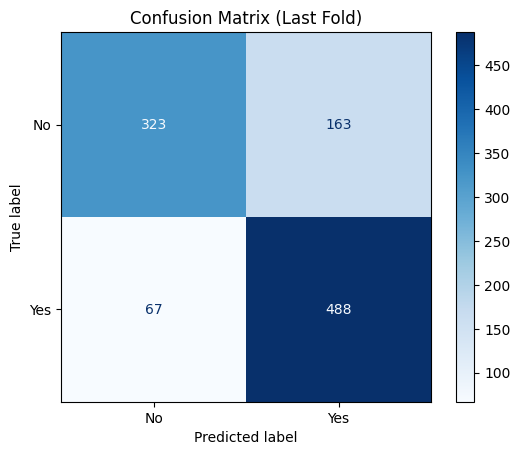

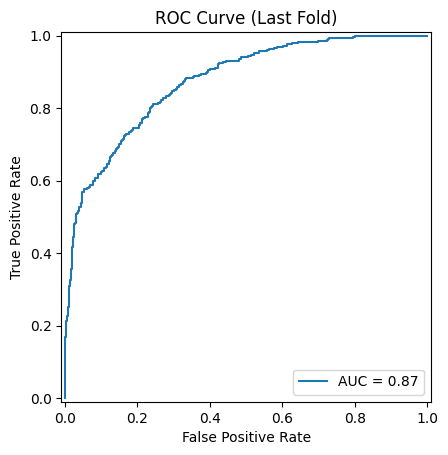

In [ ]:
# ==============================================
# 🚀 Hospital Readmission Prediction Pipeline (Enhanced)
# ==============================================
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay

# ----------------------------
# 1. Load Data
# ----------------------------
df = pd.read_csv('/content/hospital_readmissions.csv')

# ----------------------------
# 2. Feature Engineering (Enhanced)
# ----------------------------

# Count diagnoses
df['num_diagnoses'] = df[['diag_1','diag_2','diag_3']].count(axis=1)

# Total procedures and medications per stay
df['total_med_procedures'] = df['n_lab_procedures'] + df['n_procedures']
d+f['med_to_stay_ratio'] = (df['n_medications'] / df['time_in_hospital']).replace([np.inf,-np.inf],0).fillna(0)

# Procedure features
df['had_procedures'] = (df['n_procedures'] > 0).astype(int)
df['procedures_per_day'] = (df['n_procedures'] / (df['time_in_hospital'] + 1)).replace([np.inf, -np.inf], 0).fillna(0)
df['procedures_vs_medications'] = (df['n_procedures'] / (df['n_medications'] + 1)).replace([np.inf, -np.inf], 0).fillna(0)
df['procedures_interaction'] = df['n_procedures'] * df['time_in_hospital']

# Age group
def simplify_age_group(age_range):
    if pd.isna(age_range): return 'Other'
    if age_range in ['[0-10)','[10-20)','[20-30)','[30-40)','[40-50)']:
        return 'Young'
    elif age_range in ['[50-60)','[60-70)','[70-80)']:
        return 'Middle-aged'
    else:
        return 'Senior'
df['age_group_simplified'] = df['age'].apply(simplify_age_group)

# Diagnosis simplification
def simplify_diag(diag):
    if pd.isna(diag): return 'Other'
    diag = str(diag).lower()
    if 'diabetes' in diag: return 'Diabetes'
    if 'circulatory' in diag: return 'Circulatory'
    if 'respiratory' in diag: return 'Respiratory'
    if 'digestive' in diag: return 'Digestive'
    if 'injury' in diag: return 'Injury'
    if 'musculoskeletal' in diag: return 'Musculoskeletal'
    return 'Other'
for c in ['diag_1','diag_2','diag_3']:
    df[c] = df[c].apply(simplify_diag)

# Binary indicators for each diagnosis group
diag_groups = ['Respiratory','Circulatory','Diabetes','Digestive','Other','Injury','Musculoskeletal','Missing']
for dg in diag_groups:
    df[f'has_{dg.lower()}_diag'] = ((df['diag_1']==dg) | (df['diag_2']==dg) | (df['diag_3']==dg)).astype(int)

# Interaction features: number of procedures per diagnosis group
for dg in diag_groups:
    df[f'{dg.lower()}_procedures_interaction'] = df[f'has_{dg.lower()}_diag'] * df['n_procedures']

# Severity mapping
diag_severity = {
    'Respiratory': 7,
    'Circulatory': 6,
    'Diabetes': 5,
    'Digestive': 4,
    'Other': 3,
    'Injury': 2,
    'Musculoskeletal': 1,
    'Missing': 0
}
for c in ['diag_1','diag_2','diag_3']:
    df[f'{c}_severity'] = df[c].map(diag_severity)

df['max_diag_severity'] = df[[f'{c}_severity' for c in ['diag_1','diag_2','diag_3']]].max(axis=1)
df['total_diag_severity'] = df[[f'{c}_severity' for c in ['diag_1','diag_2','diag_3']]].sum(axis=1)

# ----------------------------
# 3. Preprocessing
# ----------------------------
df = df.drop(['age'], axis=1)
top_n_specialties = df['medical_specialty'].value_counts().nlargest(10).index.tolist()
df['medical_specialty'] = df['medical_specialty'].apply(lambda x: x if x in top_n_specialties else 'Other')

categorical_cols = ['medical_specialty','diag_1','diag_2','diag_3','glucose_test','A1Ctest','change','diabetes_med','age_group_simplified']
numerical_cols = [c for c in df.columns if c not in categorical_cols+['readmitted']]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df['readmitted'] = df['readmitted'].map({'no':0,'yes':1})
df.columns = [str(c).replace('[','_').replace(']','_').replace('<','_').replace(',','_')
              .replace('(','_').replace(')','_').replace(' ','_') for c in df.columns]

X = df.drop('readmitted', axis=1)
y = df['readmitted']

# ----------------------------
# 4. Repeated Stratified K-Fold Evaluation
# ----------------------------
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
f1_scores, roc_scores, acc_scores = [], [], []

preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_cols)], remainder='passthrough')

for fold,(train_idx,test_idx) in enumerate(rkf.split(X_resampled,y_resampled),1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_test = X_resampled.iloc[train_idx], X_resampled.iloc[test_idx]
    y_train, y_test = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]

    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

# ----------------------------
# 5. Balance dataset
# ----------------------------
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
print("✅ Resampled shape:", X_resampled.shape, y_resampled.shape)


    # Base models
    log_clf = LogisticRegression(solver='liblinear', max_iter=2000, random_state=42).fit(X_train,y_train)

    rf_clf = RandomForestClassifier(random_state=42)
    grid_rf = GridSearchCV(rf_clf, {'n_estimators':[100],'max_depth':[10,20]}, cv=3, scoring='f1', n_jobs=-1)
    grid_rf.fit(X_train,y_train)
    best_rf = grid_rf.best_estimator_

    xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
    grid_xgb = GridSearchCV(xgb_clf, {'n_estimators':[100],'learning_rate':[0.1],'max_depth':[3,5]}, cv=3, scoring='f1', n_jobs=-1)
    grid_xgb.fit(X_train,y_train)
    best_xgb = grid_xgb.best_estimator_

    # Stacking
    stack_clf = StackingClassifier(estimators=[('lr',log_clf),('rf',best_rf),('xgb',best_xgb)],
                                   final_estimator=LogisticRegression(), cv=3, n_jobs=-1)
    stack_clf.fit(X_train,y_train)

    # Threshold search
    y_probs = stack_clf.predict_proba(X_test)[:,1]
    thresholds = np.arange(0.1,0.9,0.01)
    best_thresh, best_f1 = 0.5, 0
    for t in thresholds:
        f1 = f1_score(y_test,(y_probs>=t).astype(int))
        if f1 > best_f1:
            best_f1, best_thresh = f1, t

    y_pred = (y_probs>=best_thresh).astype(int)
    fold_acc = accuracy_score(y_test,y_pred)
    print(f"Fold {fold} -> Acc: {fold_acc:.4f}, F1: {best_f1:.4f}, ROC-AUC: {roc_auc_score(y_test,y_probs):.4f}")

    f1_scores.append(best_f1)
    roc_scores.append(roc_auc_score(y_test,y_probs))
    acc_scores.append(fold_acc)

print("\n✅ Average F1:",np.mean(f1_scores))
print("✅ Average ROC-AUC:",np.mean(roc_scores))
print("✅ Average Accuracy:",np.mean(acc_scores))

# ----------------------------
# 6. Visualization (Last fold)
# ----------------------------
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No','Yes'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Last Fold)")
plt.show()

# ROC Curve
roc_auc = roc_auc_score(y_test, y_probs)
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_disp.plot()
plt.title("ROC Curve (Last Fold)")
plt.show()
